## Init fast book

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.all import *

     |████████████████████████████████| 720 kB 12.7 MB/s 
     |████████████████████████████████| 46 kB 2.3 MB/s 
     |████████████████████████████████| 1.2 MB 26.3 MB/s 
     |████████████████████████████████| 189 kB 54.8 MB/s 
     |████████████████████████████████| 56 kB 2.9 MB/s 
     |████████████████████████████████| 51 kB 194 kB/s 
Mounted at /content/gdrive


## Load data

In [ ]:
matplotlib.rc('image', cmap='Greys')
path = untar_data(URLs.MNIST_SAMPLE)

In [ ]:
Path.BASE_PATH = path
path.ls()

(#3) [Path('labels.csv'),Path('valid'),Path('train')]

In [ ]:
threes = (path/'train'/'3').ls().sorted()

In [ ]:
sevens = (path/'train'/'7').ls().sorted()

For Test show image data

In [ ]:
im3 = Image.open(threes[1])

In [ ]:
im3

In [ ]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## Tensor data

In [ ]:
three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]
len(three_tensors), len(seven_tensors)

(6131, 6265)

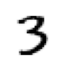

In [ ]:
show_image(three_tensors[1])

In [ ]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

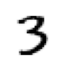

In [ ]:
show_image(stacked_threes[1])

In [ ]:
mean3 = stacked_threes.mean(0)
mean7 = stacked_sevens.mean(0)

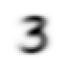

In [ ]:
show_image(mean3)

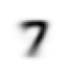

In [ ]:
show_image(mean7)

In [ ]:
valid_3_ten = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_ten = valid_3_ten.float()/255
valid_7_ten = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_ten = valid_7_ten.float()/255

valid_3_ten.shape, valid_7_ten.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

## calc distance & build a baseline



In [ ]:
data = torch.randn(2,2,2)
data

tensor([[[-0.0085,  0.7291],
         [ 0.1331,  0.8640]],

        [[-1.0157, -0.8887],
         [ 0.1498, -0.2089]]])

In [ ]:
data.mean((-1, -2))

tensor([ 0.4294, -0.4909])

In [ ]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(im3_t.float()/255, mean3)

tensor(0.1114)

In [ ]:
mnist_distance(valid_3_ten, mean3)

tensor([0.1326, 0.1243, 0.1070,  ..., 0.1183, 0.1202, 0.1117])

In [ ]:
def is_3(x): return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [ ]:
is_3(valid_3_ten)

tensor([True, True, True,  ..., True, True, True])

In [ ]:
accuracy_3s = is_3(valid_3_ten).float().mean()
accuracy_3s

tensor(0.9168)

In [ ]:
accuracy_7s = (1-is_3(valid_7_ten).float()).mean()
accuracy_7s

tensor(0.9854)

## SGD Learning Process

example

In [ ]:
def f(x) : return x**2
xt = tensor(3.).requires_grad_()
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [ ]:
yt.backward()
xt.grad

tensor(6.)

SGD optimization example

In [ ]:
time = torch.arange(0, 20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

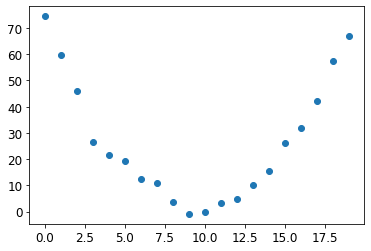

In [ ]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time, speed)

In [ ]:
def f(t, params):
  a,b,c = params
  return a*(t**2)+b*t+c

In [ ]:
def mse(preds, targets): return ((preds - targets)**2).mean().sqrt()

init with random variable

In [ ]:
params = tensor([-0.7658, -0.7506,  1.3525]).requires_grad_()
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

learn one step

In [ ]:
def show_preds(preds, ax=None):
  if ax is None: ax=plt.subplots()[1]
  ax.scatter(time, speed)
  ax.scatter(time, to_np(preds), color='red')
  ax.set_ylim(-300, 100)

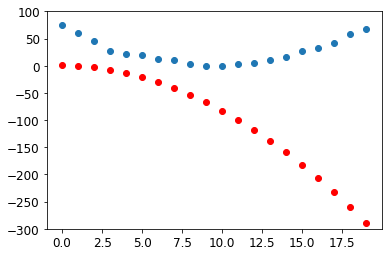

In [ ]:
preds = f(time, params)
show_preds(preds)

In [ ]:
lr = 1e-3
def learn_one_step(params, prn=True):
  preds = f(time, params)
  loss = mse(preds, speed)
  loss.backward()
  params.data -= lr * params.grad.data
  params.grad = None
  if prn : print(loss.item())
  return preds


In [ ]:
for i in range(10) : learn_one_step(params)

160.69129943847656
133.25872802734375
106.2238540649414
79.9510726928711
55.37981033325195
35.363197326660156
26.461063385009766
26.02069854736328
26.01851463317871
26.018335342407227


160.69129943847656
133.25872802734375
106.2238540649414
79.9510726928711
55.37981033325195
35.363197326660156
26.461063385009766
26.02069854736328
26.01851463317871
26.018335342407227


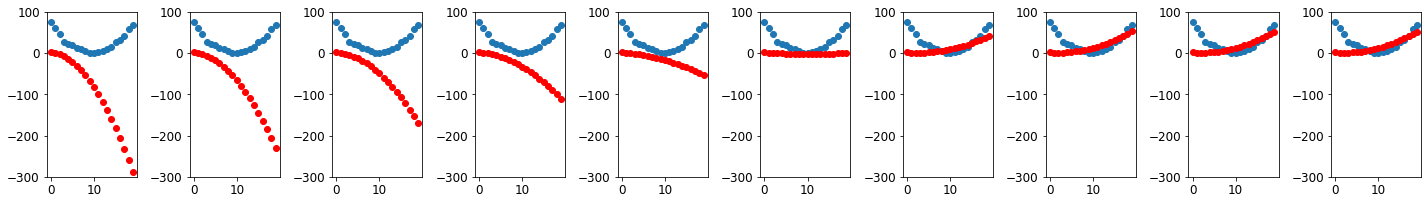

In [ ]:
params = tensor([-0.7658, -0.7506,  1.3525]).requires_grad_()
_, axs = plt.subplots(1, 10, figsize=(20, 3))
for ax in axs: show_preds(learn_one_step(params, True), ax)
plt.tight_layout()

## MINIST problem

Training and validation data set

In [ ]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [ ]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [ ]:
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [ ]:
valid_x = torch.cat([valid_3_ten, valid_7_ten]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_ten) + [0]*len(valid_7_ten)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

In [ ]:
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)

Training process

In [ ]:
def init_params(size, std=1):
  return (torch.randn(size)*std).requires_grad_()

In [ ]:
weights = init_params((28*28,1))
bias = init_params(1)
weights.shape

torch.Size([784, 1])

In [ ]:
def pred_func(x): return (x@weights + bias).sigmoid()
def mnist_loss(preds, targets): return torch.where(targets==1, 1-preds, preds).mean()

In [ ]:
def batch_accuracy(xb, yb):
  pv = pred_func(xb)
  return ((pv>0.5) == yb).float().mean()

batch_accuracy(train_x, train_y)

tensor(0.5380)

Test mnist loss 

In [ ]:
#xb,yb = first(dl)
#py = pred_func(xb)
#loss = mnist_loss(py, yb)
#loss.backward()

clear gradient

In [ ]:
#weights.grad.zero_()
#bias.grad.zero_()

AttributeError: ignored

In [ ]:
def train_epoch(model_func, lr, params):
  for xb,yb in dl:
    py = pred_func(xb)
    loss = mnist_loss(py, yb)
    loss.backward()
    for p in params:
      p.data -= p.grad * lr
      p.grad.zero_()

In [ ]:
params = weights, bias
train_epoch(pred_func, 1e-3, params)
batch_accuracy(train_x, train_y)

tensor(0.5385)

In [ ]:
params = weights, bias
for i in range(20):
  train_epoch(pred_func, 1., params)
  train_acc = batch_accuracy(train_x, train_y)
  valid_acc = batch_accuracy(valid_x, valid_y)
  print('train_acc=' +str(train_acc) + '\tvalid_acc='+ str(valid_acc))

train_acc=tensor(0.7177)	valid_acc=tensor(0.7296)
train_acc=tensor(0.8384)	valid_acc=tensor(0.8499)
train_acc=tensor(0.8986)	valid_acc=tensor(0.9009)
train_acc=tensor(0.9233)	valid_acc=tensor(0.9289)
train_acc=tensor(0.9373)	valid_acc=tensor(0.9387)
train_acc=tensor(0.9458)	valid_acc=tensor(0.9441)
train_acc=tensor(0.9528)	valid_acc=tensor(0.9524)
train_acc=tensor(0.9568)	valid_acc=tensor(0.9544)
train_acc=tensor(0.9603)	valid_acc=tensor(0.9588)
train_acc=tensor(0.9623)	valid_acc=tensor(0.9612)
train_acc=tensor(0.9639)	valid_acc=tensor(0.9622)
train_acc=tensor(0.9658)	valid_acc=tensor(0.9622)
train_acc=tensor(0.9672)	valid_acc=tensor(0.9632)
train_acc=tensor(0.9688)	valid_acc=tensor(0.9637)
train_acc=tensor(0.9701)	valid_acc=tensor(0.9647)
train_acc=tensor(0.9713)	valid_acc=tensor(0.9661)
train_acc=tensor(0.9722)	valid_acc=tensor(0.9666)
train_acc=tensor(0.9731)	valid_acc=tensor(0.9671)
train_acc=tensor(0.9739)	valid_acc=tensor(0.9671)
train_acc=tensor(0.9749)	valid_acc=tensor(0.9676)


## Using Pytorch Optimizer

In [ ]:
def mnist_loss2(preds, targets):
  predictions = preds.sigmoid()
  return torch.where(targets==1, 1-predictions, predictions).mean()

In [ ]:
def batch_accuracy2(xb, yb):
  preds = xb.sigmoid()
  correct = (preds>0.5) == yb
  return correct.float().mean()

In [ ]:
dls = DataLoaders(dl, valid_dl)
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD, 
                loss_func=mnist_loss2, metrics=batch_accuracy2)

In [ ]:
learn.fit(10, lr=1.0)

epoch,train_loss,valid_loss,batch_accuracy2,time
0,0.636506,0.503769,0.495584,00:00
1,0.631119,0.495177,0.495584,00:00
2,0.266473,0.322870,0.670265,00:00
3,0.112727,0.150155,0.866045,00:00
4,0.055678,0.096055,0.919038,00:00
5,0.033639,0.072643,0.936212,00:00
6,0.024640,0.059375,0.950442,00:00
7,0.020739,0.050868,0.957311,00:00
8,0.018871,0.045076,0.963690,00:00
9,0.017831,0.040939,0.965653,00:00


### Nonlinear

In [ ]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [ ]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss2,
                metrics=batch_accuracy2)

In [ ]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy2,time
0,0.316283,0.398510,0.510795,00:00
1,0.146307,0.233466,0.797841,00:00
2,0.081195,0.117420,0.916094,00:00
3,0.053397,0.079238,0.939156,00:00
4,0.040514,0.061798,0.954858,00:00
5,0.033934,0.051929,0.963690,00:00
6,0.030148,0.045697,0.965653,00:00
7,0.027685,0.041432,0.967125,00:00
8,0.025906,0.038340,0.968597,00:00
9,0.024524,0.035983,0.971050,00:00


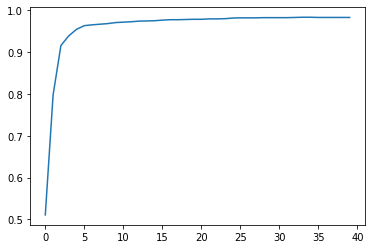

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2))

In [ ]:
learn.recorder.values[-1][2]

0.983316957950592

In [ ]:
learn.recorder.values

[(#3) [0.3162834346294403,0.3985101282596588,0.5107948780059814],
 (#3) [0.14630743861198425,0.2334664911031723,0.7978410124778748],
 (#3) [0.08119453489780426,0.11742015928030014,0.916094183921814],
 (#3) [0.053397130221128464,0.07923759520053864,0.9391560554504395],
 (#3) [0.04051406681537628,0.061797577887773514,0.9548577070236206],
 (#3) [0.03393350541591644,0.05192887410521507,0.9636898636817932],
 (#3) [0.03014814294874668,0.04569659009575844,0.965652585029602],
 (#3) [0.027685144916176796,0.041432157158851624,0.9671246409416199],
 (#3) [0.02590554766356945,0.03834037482738495,0.9685966372489929],
 (#3) [0.024524321779608727,0.03598342463374138,0.9710500240325928],
 (#3) [0.023401904851198196,0.03411860391497612,0.9720314145088196],
 (#3) [0.022465310990810394,0.0325905904173851,0.9730127453804016],
 (#3) [0.021666597574949265,0.03130767494440079,0.9744848012924194],
 (#3) [0.0209751445800066,0.03020828403532505,0.9749754667282104],
 (#3) [0.020368820056319237,0.02925105020403862

## More Layers Deeper Models
With deeper model(that is, one with more layers) we do not need to use as many parameters; it turns out that we can use smaller matrices with more layers, and get better result than we would get with larger matrices, and few layers.

In [ ]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, 
                    metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.140873,0.029595,0.994603,02:37
